In [1]:
import os
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import random
from collections import namedtuple, deque

In [2]:
from os import path
from typing import Optional

from gym import spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled

In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
DEFAULT_X = np.pi
DEFAULT_Y = 1.0

In [5]:
class PendulumEnv(gym.Env):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode: Optional[str] = None, g=10.0):
        self.max_speed = 8
        self.max_torque = 2.0
        self.dt = 0.05
        self.g = g
        self.m = 0.5
        self.l = 1.0
        self.b = 0.1

        self.render_mode = render_mode

        self.screen_dim = 500
        self.screen = None
        self.clock = None
        self.isopen = True

        high = np.array([1.0, 1.0, self.max_speed], dtype=np.float32)
        # This will throw a warning in tests/envs/test_envs in utils/env_checker.py as the space is not symmetric
        #   or normalised as max_torque == 2 by default. Ignoring the issue here as the default settings are too old
        #   to update to follow the openai gym api
        self.action_space = spaces.Box(
            low=-self.max_torque, high=self.max_torque, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

    def angle_normalize(self, x):
      return ((x + np.pi) % (2 * np.pi)) - np.pi

    def step(self, u):
        th, thdot = self.state  # th := theta

        g = self.g
        m = self.m
        l = self.l
        dt = self.dt

        u = np.clip(u, -self.max_torque, self.max_torque)
        self.last_u = u  # for rendering
        costs = self.angle_normalize(th) ** 2 + 0.1 * thdot**2 + 0.001 * (u**2)
        newthdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l**2) * u - self.b*thdot/(m*l**2)) * dt

        newthdot = np.clip(newthdot, -self.max_speed, self.max_speed)
        newth = th + newthdot * dt

        self.state = np.array([newth, newthdot])

        if self.render_mode == "human":
            self.render()
        
        return self._get_obs(), -costs, False, False, {}

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        if options is None:
            high = np.array([DEFAULT_X, DEFAULT_Y])
        else:
            # Note that if you use custom reset bounds, it may lead to out-of-bound
            # state/observations.
            x = options.get("x_init") if "x_init" in options else DEFAULT_X
            y = options.get("y_init") if "y_init" in options else DEFAULT_Y
            x = utils.verify_number_and_cast(x)
            y = utils.verify_number_and_cast(y)
            high = np.array([x, y])
        low = -high  # We enforce symmetric limits.
        self.state = self.np_random.uniform(low=low, high=high)
        self.last_u = None

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), {}

    def _get_obs(self):
        theta, thetadot = self.state
        return np.array([np.cos(theta), np.sin(theta), thetadot], dtype=np.float32)

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_dim, self.screen_dim)
                )
            else:  # mode in "rgb_array"
                self.screen = pygame.Surface((self.screen_dim, self.screen_dim))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        self.surf = pygame.Surface((self.screen_dim, self.screen_dim))
        self.surf.fill((255, 255, 255))

        bound = 2.2
        scale = self.screen_dim / (bound * 2)
        offset = self.screen_dim // 2

        rod_length = 1 * scale
        rod_width = 0.2 * scale
        l, r, t, b = 0, rod_length, rod_width / 2, -rod_width / 2
        coords = [(l, b), (l, t), (r, t), (r, b)]
        transformed_coords = []
        for c in coords:
            c = pygame.math.Vector2(c).rotate_rad(self.state[0] + np.pi / 2)
            c = (c[0] + offset, c[1] + offset)
            transformed_coords.append(c)
        gfxdraw.aapolygon(self.surf, transformed_coords, (204, 77, 77))
        gfxdraw.filled_polygon(self.surf, transformed_coords, (204, 77, 77))

        gfxdraw.aacircle(self.surf, offset, offset, int(rod_width / 2), (204, 77, 77))
        gfxdraw.filled_circle(
            self.surf, offset, offset, int(rod_width / 2), (204, 77, 77)
        )

        rod_end = (rod_length, 0)
        rod_end = pygame.math.Vector2(rod_end).rotate_rad(self.state[0] + np.pi / 2)
        rod_end = (int(rod_end[0] + offset), int(rod_end[1] + offset))
        gfxdraw.aacircle(
            self.surf, rod_end[0], rod_end[1], int(rod_width / 2), (204, 77, 77)
        )
        gfxdraw.filled_circle(
            self.surf, rod_end[0], rod_end[1], int(rod_width / 2), (204, 77, 77)
        )

        fname = path.join(path.dirname(__file__), "assets/clockwise.png")
        img = pygame.image.load(fname)
        if self.last_u is not None:
            scale_img = pygame.transform.smoothscale(
                img,
                (scale * np.abs(self.last_u) / 2, scale * np.abs(self.last_u) / 2),
            )
            is_flip = bool(self.last_u > 0)
            scale_img = pygame.transform.flip(scale_img, is_flip, True)
            self.surf.blit(
                scale_img,
                (
                    offset - scale_img.get_rect().centerx,
                    offset - scale_img.get_rect().centery,
                ),
            )

        # drawing axle
        gfxdraw.aacircle(self.surf, offset, offset, int(0.05 * scale), (0, 0, 0))
        gfxdraw.filled_circle(self.surf, offset, offset, int(0.05 * scale), (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        else:  # mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [6]:
cObject = PendulumEnv()
cObject.reset()
cState, cReward, info, done, _ = cObject.step(1.0)
print(cState)

[-0.4836498 -0.8752616 -1.0553883]


In [7]:
class ReplayBuffer():
    def __init__(self, buffer_limit, DEVICE):
        self.buffer = deque(maxlen=buffer_limit)
        self.dev = DEVICE

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0
            done_mask_lst.append([done_mask])

        s_batch = torch.tensor(s_lst, dtype=torch.float).to(self.dev)
        a_batch = torch.tensor(a_lst, dtype=torch.float).to(self.dev)
        r_batch = torch.tensor(r_lst, dtype=torch.float).to(self.dev)
        s_prime_batch = torch.tensor(s_prime_lst, dtype=torch.float).to(self.dev)
        done_batch = torch.tensor(done_mask_lst, dtype=torch.float).to(self.dev)

        # r_batch = (r_batch - r_batch.mean()) / (r_batch.std() + 1e-7)

        return s_batch, a_batch, r_batch, s_prime_batch, done_batch

    def size(self):
        return len(self.buffer)


class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, actor_lr):
        super(PolicyNetwork, self).__init__()

        self.fc_1 = nn.Linear(state_dim, 64)
        self.fc_2 = nn.Linear(64, 64)
        self.fc_mu = nn.Linear(64, action_dim)
        self.fc_std = nn.Linear(64, action_dim)

        self.lr = actor_lr

        self.LOG_STD_MIN = -20
        self.LOG_STD_MAX = 2
        self.max_action = 2
        self.min_action = -2
        self.action_scale = (self.max_action - self.min_action) / 2.0
        self.action_bias = (self.max_action + self.min_action) / 2.0

        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        x = F.leaky_relu(self.fc_1(x))
        x = F.leaky_relu(self.fc_2(x))
        mu = self.fc_mu(x)
        log_std = self.fc_std(x)
        log_std = torch.clamp(log_std, self.LOG_STD_MIN, self.LOG_STD_MAX)
        return mu, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = torch.exp(log_std)
        reparameter = Normal(mean, std)
        x_t = reparameter.rsample()
        y_t = torch.tanh(x_t)
        action = self.action_scale * y_t + self.action_bias

        # # Enforcing Action Bound
        log_prob = reparameter.log_prob(x_t)
        log_prob = log_prob - torch.sum(torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6), dim=-1, keepdim=True)

        return action, log_prob


class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, critic_lr):
        super(QNetwork, self).__init__()

        self.fc_s = nn.Linear(state_dim, 32)
        self.fc_a = nn.Linear(action_dim, 32)
        self.fc_1 = nn.Linear(64, 64)
        self.fc_out = nn.Linear(64, action_dim)

        self.lr = critic_lr

        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x, a):
        h1 = F.leaky_relu(self.fc_s(x))
        h2 = F.leaky_relu(self.fc_a(a))
        cat = torch.cat([h1, h2], dim=-1)
        q = F.leaky_relu(self.fc_1(cat))
        q = self.fc_out(q)
        return q


class SAC_Agent:
    def __init__(self):
        self.state_dim      = 3  # [cos(theta), sin(theta), theta_dot]
        self.action_dim     = 1  # [torque] in[-2,2]
        self.lr_pi          = 0.01
        self.lr_q           = 0.01
        self.gamma          = 0.98
        self.batch_size     = 200
        self.buffer_limit   = 100000
        self.tau            = 0.005
        self.init_alpha     = 0.01
        self.target_entropy = -self.action_dim  # == -1
        self.lr_alpha       = 0.005
        self.DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.memory         = ReplayBuffer(self.buffer_limit, self.DEVICE)

        self.log_alpha = torch.tensor(np.log(self.init_alpha)).to(self.DEVICE)
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = optim.Adam([self.log_alpha], lr=self.lr_alpha)

        self.PI  = PolicyNetwork(self.state_dim, self.action_dim, self.lr_pi).to(self.DEVICE)
        self.Q1        = QNetwork(self.state_dim, self.action_dim, self.lr_q).to(self.DEVICE)
        self.Q1_target = QNetwork(self.state_dim, self.action_dim, self.lr_q).to(self.DEVICE)
        self.Q2        = QNetwork(self.state_dim, self.action_dim, self.lr_q).to(self.DEVICE)
        self.Q2_target = QNetwork(self.state_dim, self.action_dim, self.lr_q).to(self.DEVICE)

        self.Q1_target.load_state_dict(self.Q1.state_dict())
        self.Q2_target.load_state_dict(self.Q2.state_dict())

    def choose_action(self, s):
        with torch.no_grad():
            action, log_prob = self.PI.sample(s.to(self.DEVICE))
        return action, log_prob

    def calc_target(self, mini_batch):
        s, a, r, s_prime, done = mini_batch
        with torch.no_grad():
            a_prime, log_prob_prime = self.PI.sample(s_prime)
            entropy = - self.log_alpha.exp() * log_prob_prime
            q1_target, q2_target = self.Q1_target(s_prime, a_prime), self.Q2_target(s_prime, a_prime)
            q_target = torch.min(q1_target, q2_target)
            target = r + self.gamma * done * (q_target + entropy)
        return target

    def train_agent(self):
        mini_batch = self.memory.sample(self.batch_size)
        s_batch, a_batch, r_batch, s_prime_batch, done_batch = mini_batch

        td_target = self.calc_target(mini_batch)

        #### Q1 train ####
        q1_loss = F.smooth_l1_loss(self.Q1(s_batch, a_batch), td_target)
        self.Q1.optimizer.zero_grad()
        q1_loss.mean().backward()
        self.Q1.optimizer.step()
        #### Q1 train ####

        #### Q2 train ####
        q2_loss = F.smooth_l1_loss(self.Q2(s_batch, a_batch), td_target)
        self.Q2.optimizer.zero_grad()
        q2_loss.mean().backward()
        self.Q2.optimizer.step()
        #### Q2 train ####

        #### pi train ####
        a, log_prob = self.PI.sample(s_batch)
        entropy = -self.log_alpha.exp() * log_prob

        q1, q2 = self.Q1(s_batch, a), self.Q2(s_batch, a)
        q = torch.min(q1, q2)

        pi_loss = -(q + entropy) 
        self.PI.optimizer.zero_grad()
        pi_loss.mean().backward()
        self.PI.optimizer.step()
        #### pi train ####

        #### alpha train ####
        self.log_alpha_optimizer.zero_grad()
        alpha_loss = -(self.log_alpha.exp() * (log_prob + self.target_entropy).detach()).mean()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()
        #### alpha train ####

        #### Q1, Q2 soft-update ####
        for param_target, param in zip(self.Q1_target.parameters(), self.Q1.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)
        for param_target, param in zip(self.Q2_target.parameters(), self.Q2.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)
        #### Q1, Q2 soft-update ####

In [8]:
agent = SAC_Agent()

EPISODE = 100
print_once = True
score_list = []

for EP in range(EPISODE):
    state = cObject.reset()
    state = state[0]
    state[0] = -1
    state[1] = 0
    # print((state))
    score, done = 0.0, False
    itr = 500
    count = 0
    while not done and itr >=0:
        itr -= 1
        action, log_prob = agent.choose_action(torch.FloatTensor(state))
        action = action.detach().cpu().numpy() 
        state_prime, reward, done,*_ = cObject.step(action)
        state_prime = state_prime.ravel()  
        reward = reward[0]
        # print(done)
        # print(action, log_prob)
        # print(state_prime, reward)
        agent.memory.put((state, action, reward, state_prime, done))
        score += reward

        state = state_prime

        if agent.memory.size() > 1000:  
            agent.train_agent()
        # count += 1

    print("EP:{}, Avg_Score:{:.1f}".format(EP, score))
    score_list.append(score)


EP:0, Avg_Score:-3493.8


/tmp/ipykernel_22067/2206078547.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  s_batch = torch.tensor(s_lst, dtype=torch.float).to(self.dev)


EP:1, Avg_Score:-3455.6
EP:2, Avg_Score:-4041.8
EP:3, Avg_Score:-3013.8
EP:4, Avg_Score:-2623.0
EP:5, Avg_Score:-2556.8
EP:6, Avg_Score:-2029.1
EP:7, Avg_Score:-2577.5
EP:8, Avg_Score:-142.6
EP:9, Avg_Score:-3.4
EP:10, Avg_Score:-136.1
EP:11, Avg_Score:-120.5
EP:12, Avg_Score:-131.9
EP:13, Avg_Score:-2.8
EP:14, Avg_Score:-141.6
EP:15, Avg_Score:-108.1
EP:16, Avg_Score:-147.0
EP:17, Avg_Score:-145.9
EP:18, Avg_Score:-144.8
EP:19, Avg_Score:-124.8
EP:20, Avg_Score:-131.7
EP:21, Avg_Score:-4.7
EP:22, Avg_Score:-164.5
EP:23, Avg_Score:-119.4
EP:24, Avg_Score:-123.6
EP:25, Avg_Score:-5.7
EP:26, Avg_Score:-16.4
EP:27, Avg_Score:-106.4
EP:28, Avg_Score:-111.2
EP:29, Avg_Score:-134.2
EP:30, Avg_Score:-8.9
EP:31, Avg_Score:-121.9
EP:32, Avg_Score:-133.6
EP:33, Avg_Score:-258.5
EP:34, Avg_Score:-141.6
EP:35, Avg_Score:-124.6
EP:36, Avg_Score:-109.0
EP:37, Avg_Score:-124.8
EP:38, Avg_Score:-125.6
EP:39, Avg_Score:-114.0
EP:40, Avg_Score:-223.6
EP:41, Avg_Score:-11.3
EP:42, Avg_Score:-121.3
EP:43,

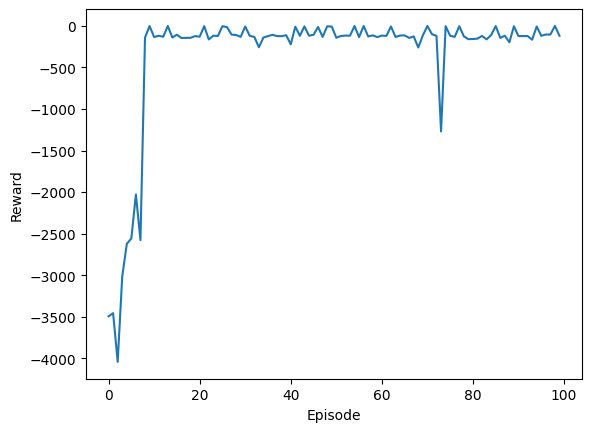

In [9]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(score_list)), score_list)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()